In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from relbench.datasets import get_dataset

import utils

%load_ext autoreload
%autoreload 2

# graphs too large for interactivity
pio.renderers.default = 'svg'

In [2]:
dataset = get_dataset(name='rel-math-stackex', process=True)

making Database object from raw files...
Loading data from: /Users/adobles/Library/Caches/pooch/25a03b9a227fa6fadbd949a4ea4721f2-relbench-stackex-raw/math-stackex-temp


/Users/adobles/projects/snap/relbench/relbench/datasets/math_stackex.py:56: DtypeWarning:

Columns (0,1,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/adobles/projects/snap/relbench/relbench/datasets/math_stackex.py:62: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Data loaded
Percentage of rows removed due to invalid dates: 4.21%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
done in 201.62 seconds.
reindexing pkeys and fkeys...
done in 25.14 seconds.


In [3]:
dataset.db.table_dict.keys()

dict_keys(['comments', 'badges', 'postLinks', 'postHistory', 'votes', 'users', 'posts'])

#### Schema:
[Full Schema](https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede/2678#2678)

![|500](https://relbench.stanford.edu/img/stack-exchange.png)

## Tasks

### `rel-stackex-engage`

Task is to predict if a user will make any engagement (vote, comment or post) on the site in the
next 2 years.

Filter: users who have made at least one comment/post/vote before the timestamp

ML task: Binary Classification

Evaluation Metric: AP

In [4]:
task = dataset.get_task('rel-stackex-engage', process=True)

In [5]:
task.train_table.df.columns

Index(['timestamp', 'OwnerUserId', 'contribution'], dtype='object')

In [6]:
print('TRAIN\n')

print(f'{len(task.train_table.df):,} samples over {task.train_table.df.OwnerUserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.train_table.df.contribution.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.train_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.train_table.df
    .drop_duplicates(subset='OwnerUserId', keep='last')
    .groupby('timestamp').OwnerUserId.nunique() / task.train_table.df.OwnerUserId.nunique()
)

TRAIN

300,850 samples over 174,778 users.

Label Distribution:
contribution
0    0.827027
1    0.172973
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2011-01    0.005913
2013-01    0.090889
2015-01    0.322250
2017-01    0.580947
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2011-01-03    0.005252
2013-01-02    0.057015
2015-01-02    0.236786
2017-01-01    0.700946
Name: OwnerUserId, dtype: float64


In [7]:
print('VAL\n')

print(f'{len(task.val_table.df):,} samples over {task.val_table.df.OwnerUserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.val_table.df.contribution.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.val_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'User overlap between train and val: {len(set(task.train_table.df.OwnerUserId) & set(task.val_table.df.OwnerUserId)):,}')

VAL

242,163 samples over 242,163 users.

Label Distribution:
contribution
0    0.88096
1    0.11904
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2019-01    1.0
Name: proportion, dtype: float64

User overlap between train and val: 174,778


**Notes**:

- `timestamp` is chopped up into two-year chunks rather than a finer grain (which would yield more samples per user)
- Train-val split is temporal
- Val is almost as large as train -- reflects the growth of the platform probably. Number of samples (& users) biased towards recent years.
- All users in train appear in val -- when evaluating look at performance diff b/w in-train and out-of-train user sets.

### `rel-stackex-votes`

Task is to predict if the number of upvotes a question will get in the following 6 months.

Filter: questions older than 2 years before timestamp to avoid predictions on stale questions.

ML task: Regression

Evaluation Metric: MAE

In [8]:
task = dataset.get_task('rel-stackex-votes', process=True)

In [9]:
task.train_table.df.columns

Index(['timestamp', 'PostId', 'popularity'], dtype='object')

TRAIN

1,080,861 samples over 653,507 posts.

Temporal dist of samples:
timestamp
2011-01    0.003549
2013-01    0.077767
2015-01    0.314067
2017-01    0.604617
Name: proportion, dtype: float64

Temporal dist of posts (first appearance):
timestamp
2011-01-03    0.002234
2013-01-02    0.063488
2015-01-02    0.227052
2017-01-01    0.707226
Name: PostId, dtype: float64

Label Distribution:
Mean (std): 0.3 ± 2.1
Median: 0.0
Prop zeros: 83.3%


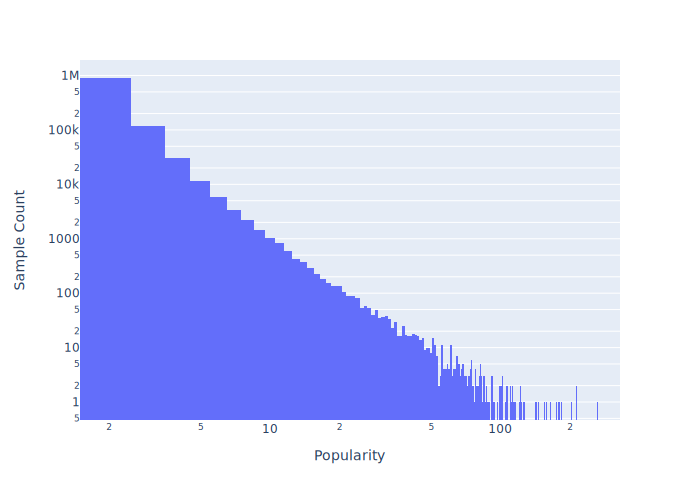

In [16]:
print('TRAIN\n')

print(f'{len(task.train_table.df):,} samples over {task.train_table.df.PostId.nunique():,} posts.')
print()
print('Temporal dist of samples:')
print(task.train_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of posts (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.train_table.df
    .drop_duplicates(subset='PostId', keep='last')
    .groupby('timestamp').PostId.nunique() / task.train_table.df.PostId.nunique()
)
print()
print('Label Distribution:')
mean = task.train_table.df.popularity.mean()
std = task.train_table.df.popularity.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Median: {task.train_table.df.popularity.quantile(0.5)}')
print(f'Prop zeros: {(task.train_table.df.popularity == 0).mean():.1%}')
fig = px.histogram(x=task.train_table.df.popularity + 1, log_x=True, log_y=True)
# ^-- add 1 so log scale shows
fig.update_layout(xaxis_title='Popularity', yaxis_title='Sample Count')

VAL

964,097 samples over 964,097 posts.

Temporal dist of samples:
timestamp
2019-01    1.0
Name: proportion, dtype: float64

Temporal dist of posts (first appearance):
timestamp
2019-01-01    1.0
Name: PostId, dtype: float64

Label Distribution:
Mean (std): 0.2 ± 1.2
Median: 0.0
Prop zeros: 88.9%


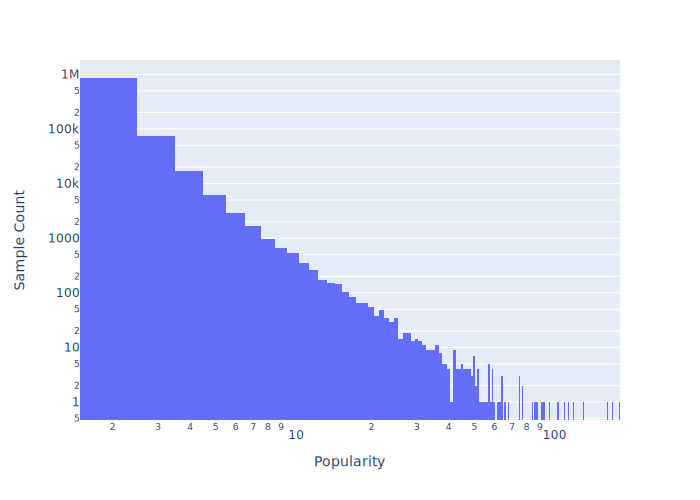

In [17]:
print('VAL\n')

print(f'{len(task.val_table.df):,} samples over {task.val_table.df.PostId.nunique():,} posts.')
print()
print('Temporal dist of samples:')
print(task.val_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of posts (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.val_table.df
    .drop_duplicates(subset='PostId', keep='last')
    .groupby('timestamp').PostId.nunique() / task.val_table.df.PostId.nunique()
)
print()
print('Label Distribution:')
mean = task.val_table.df.popularity.mean()
std = task.val_table.df.popularity.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Median: {task.val_table.df.popularity.quantile(0.5)}')
print(f'Prop zeros: {(task.val_table.df.popularity == 0).mean():.1%}')
fig = px.histogram(x=task.val_table.df.popularity + 1, log_x=True, log_y=True)
# ^-- add 1 so log scale shows
fig.update_layout(xaxis_title='Popularity', yaxis_title='Sample Count')

**Notes**:
- Label is incredibly skewed (vast majority of labels are 0)
- Will be hard to learn a good model --> could consider just doing classfication (0 vs nonzero) + some regression on the nonzero part

### `rel-stackex-badges`

TODO Fill out
Task is to predict if the number of upvotes a question will get in the following 6 months.

Filter: questions older than 2 years before timestamp to avoid predictions on stale questions.

ML task: Binary Classification

Evaluation Metric: AUC?

In [18]:
task = dataset.get_task('rel-stackex-badges', process=True)

In [19]:
task.train_table.df.columns

Index(['timestamp', 'UserId', 'WillGetBadge'], dtype='object')

In [21]:
print('TRAIN\n')

print(f'{len(task.train_table.df):,} samples over {task.train_table.df.UserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.train_table.df.WillGetBadge.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.train_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.train_table.df
    .drop_duplicates(subset='UserId', keep='last')
    .groupby('timestamp').UserId.nunique() / task.train_table.df.UserId.nunique()
)

TRAIN

399,200 samples over 232,317 users.

Label Distribution:
WillGetBadge
0    0.700458
1    0.299542
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2011-01    0.008464
2013-01    0.093950
2015-01    0.315629
2017-01    0.581956
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2011-01-03    0.005574
2013-01-02    0.037746
2015-01-02    0.269571
2017-01-01    0.687109
Name: UserId, dtype: float64


In [22]:
print('VAL\n')

print(f'{len(task.val_table.df):,} samples over {task.val_table.df.UserId.nunique():,} users.')
print()
print('Label Distribution:')
print(task.val_table.df.WillGetBadge.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(task.val_table.df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    task.val_table.df
    .drop_duplicates(subset='UserId', keep='last')
    .groupby('timestamp').UserId.nunique() / task.val_table.df.UserId.nunique()
)

VAL

341,359 samples over 341,359 users.

Label Distribution:
WillGetBadge
0    0.766952
1    0.233048
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2019-01    1.0
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2019-01-01    1.0
Name: UserId, dtype: float64


## Raw Data

### Users

In [8]:
users = dataset.db.table_dict['users'].df

In [9]:
users.head()

,Id,AboutMe,AccountId,CreationDate,DisplayName,WebsiteUrl,Location
0,0,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",-1.0,2010-07-20 14:51:15.677,Community,http://meta.stackexchange.com/,on the server farm
1,1,<p>Dev #2 who helped create Stack Overflow cur...,2.0,2010-07-20 15:33:13.347,Geoff Dalgas,http://stackoverflow.com,"Corvallis, OR"
2,2,<p>My name is Benjamin Dumke-von der Ehe. I wo...,40051.0,2010-07-20 16:03:31.233,balpha,https://social.balpha.de/@balpha,"Berlin, Germany"
3,3,"<p>Officially voted <a href=""https://twitter.c...",32917.0,2010-07-20 17:01:31.377,David Fullerton,NaN,"Melbourne, FL, USA"
4,4,<p>I used to design stuff for Stack Exchange. ...,21721.0,2010-07-20 17:05:37.000,Jin,http://www.8164.org,"Raleigh, NC"


In [10]:
# Check NaNs
users.isna().mean()

Id              0.000000
AboutMe         0.760423
AccountId       0.000000
CreationDate    0.000000
DisplayName     0.000112
WebsiteUrl      0.888141
Location        0.739342
dtype: float64

In [11]:
users.Location.apply(lambda x: str(x).split(',')[-1].strip()).value_counts(normalize=True)

Location
nan                                                         0.739342
India                                                       0.028913
United States                                               0.020241
USA                                                         0.018945
Germany                                                     0.010273
                                                              ...   
Kruševac                                                    0.000002
Somewhere on the sea                                        0.000002
Boston MA 02215                                             0.000002
Nonlinear Multivariate Dynamic Stochastic Global Optimum    0.000002
Eres                                                        0.000002
Name: proportion, Length: 6297, dtype: float64

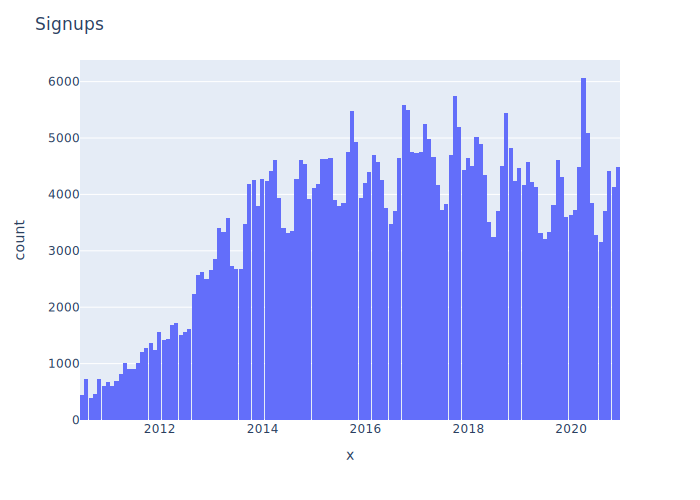

In [12]:
fig = px.histogram(x=users.CreationDate.dt.strftime('%Y-%m'))
fig.update_layout(height=500, width=700, title='Signups')

**Notes**:
- Some obvious features related to NaNs: eg nan aboutMe, nan location, nan website
- Use creation date for months_since_creation
- Would be nice to know when they edited profile last.
- Seasonal dip in signups in July/August (maybe b/c school's out!) -- check if seasonality extends to posts too

### Badges

In [13]:
badges = dataset.db.table_dict['badges'].df

In [14]:
badges.sample(n=15)

,Id,Date,Class,UserId,Name,TagBased
1455597,1455597,2020-01-12 20:45:40.247,3,389246,Student,False
947421,947421,2017-09-11 14:04:26.753,3,269265,Student,False
695317,695317,2016-05-27 22:34:26.027,3,237,Nice Answer,False
1051862,1051862,2018-02-20 18:16:34.017,3,296291,Editor,False
1286010,1286010,2019-03-30 10:25:19.613,3,339761,Vox Populi,False
233108,233108,2013-12-23 03:00:55.463,3,8050,calculus,True
1309898,1309898,2019-05-12 17:30:40.270,3,39568,Popular Question,False
1628389,1628389,2020-10-29 22:57:46.277,3,387003,Teacher,False
727942,727942,2016-08-09 04:53:09.723,3,208921,Informed,False
988514,988514,2017-11-04 21:56:46.153,3,60256,Custodian,False


In [15]:
badges.isna().mean()

Id          0.000000
Date        0.000000
Class       0.000000
UserId      0.000011
Name        0.000000
TagBased    0.000000
dtype: float64

In [16]:
badges.TagBased.value_counts(normalize=True)

TagBased
False    0.99157
True     0.00843
Name: proportion, dtype: float64

In [17]:
badges.Name.value_counts(normalize=True)

Name
Student                     1.251423e-01
Editor                      9.841675e-02
Scholar                     8.558863e-02
Supporter                   7.718365e-02
Popular Question            7.701854e-02
                                ...     
trigonometric-series        6.003987e-07
supremum-and-infimum        6.003987e-07
geometric-construction      6.003987e-07
sturm-liouville             6.003987e-07
low-dimensional-topology    6.003987e-07
Name: proportion, Length: 584, dtype: float64

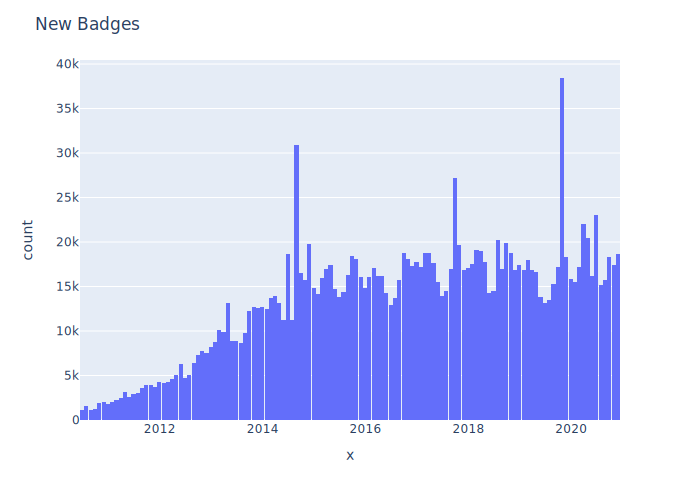

In [18]:
fig = px.histogram(x=badges.Date.dt.strftime('%Y-%m'))
fig.update_layout(height=500, width=700, title='New Badges')

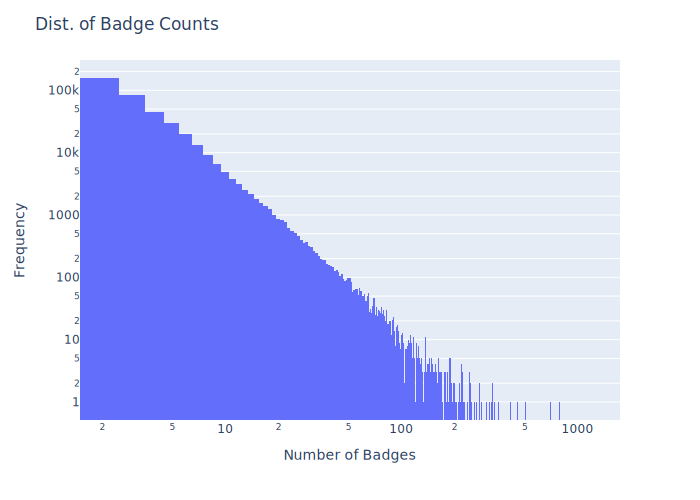

In [19]:
# Distribution of num tags
fig = px.histogram(x=badges.groupby('UserId').size(), log_x=True, log_y=True)
fig.update_layout(height=500, width=700, title='Dist. of Badge Counts',
                  xaxis_title='Number of Badges', yaxis_title='Frequency')

**Notes**
- Same seasonality observed (summer lull)
- The number of badges by user obeys a power law
- Can probably aggregate a users badges into a single feature that captures the sum total of their badges weighted by rarity
- Interesting to look at time since last badge and rarity of last badge by user

### Posts

In [20]:
posts = dataset.db.table_dict['posts'].df
print(f'Total Posts: {len(posts):,}')

Total Posts: 3,141,289


In [21]:
posts.sample(n=15)

,Tags,ParentId,AcceptedAnswerId,Title,OwnerDisplayName,Id,ContentLicense,CreationDate,PostTypeId,Body,OwnerUserId
2056828,<geometry><contest-math>,<NA>,2056834,Inscribed unit square problem:,NaN,2056828,CC BY-SA 3.0,2017-12-03 04:04:45.790,1,<p>A picture has a cross made from five unit s...,262141
807225,<real-analysis><general-topology><analysis><fu...,<NA>,807234,"Is the function $\,f(x, y) = x-y\,$ closed?",NaN,807225,CC BY-SA 3.0,2014-10-13 06:39:54.540,1,"<p>Is the function $\,\,f: \mathbb{R}\times \m...",75643
397317,NaN,397307,<NA>,NaN,NaN,397317,CC BY-SA 3.0,2013-08-05 05:41:52.310,2,"<p>Not continuously, no. If the vector field $...",57658
282643,<approximation>,<NA>,<NA>,Approximations with differentials,NaN,282643,CC BY-SA 3.0,2013-03-10 09:58:36.903,1,<p>My book states that for <strong>large <em>n...,16798
1500667,NaN,1500665,<NA>,NaN,NaN,1500667,CC BY-SA 3.0,2016-07-06 11:05:24.807,2,"<p>In question 1, you can define the function ...",191225
2015620,NaN,2015597,<NA>,NaN,NaN,2015620,CC BY-SA 3.0,2017-10-30 00:28:42.697,2,"<p>Hint 1: $d_H(\chi_n, [0,1])$ is monotone de...",646
2016274,<combinatorics>,<NA>,<NA>,Permutation of objects not all distinct,NaN,2016274,CC BY-SA 3.0,2017-10-30 13:58:29.350,1,<p>The number of permutations of the letters o...,265233
1200918,NaN,1200897,<NA>,NaN,NaN,1200918,CC BY-SA 3.0,2015-10-11 09:02:13.780,2,"<p>There is a Borel set $B$ such that, for eve...",19479
1606777,NaN,1606768,<NA>,NaN,NaN,1606777,CC BY-SA 3.0,2016-10-25 00:37:44.723,2,"<p>The sets in <a href=""https://math.stackexch...",7455
93992,NaN,93989,<NA>,NaN,user21436,93992,CC BY-SA 3.0,2012-02-04 16:07:24.997,2,<p>Your intuition that that difference between...,<NA>


In [22]:
posts.PostTypeId.value_counts(normalize=True)

PostTypeId
2    0.578497
1    0.420174
4    0.000647
5    0.000647
6    0.000032
7    0.000001
3    0.000001
Name: proportion, dtype: float64

In [23]:
posts.ContentLicense.value_counts(normalize=True)

ContentLicense
CC BY-SA 3.0    0.683692
CC BY-SA 4.0    0.309029
CC BY-SA 2.5    0.007279
Name: proportion, dtype: float64

In [24]:
posts.isna().mean()

Tags                0.579826
ParentId            0.421504
AcceptedAnswerId    0.773097
Title               0.579826
OwnerDisplayName    0.952916
Id                  0.000000
ContentLicense      0.000000
CreationDate        0.000000
PostTypeId          0.000000
Body                0.000164
OwnerUserId         0.045332
dtype: float64

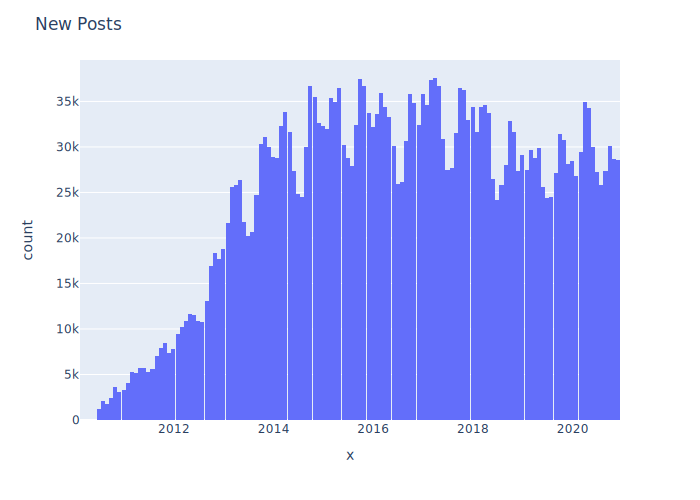

In [25]:
fig = px.histogram(x=posts.CreationDate.dt.strftime('%Y-%m'))
fig.update_layout(height=500, width=700, title='New Posts')

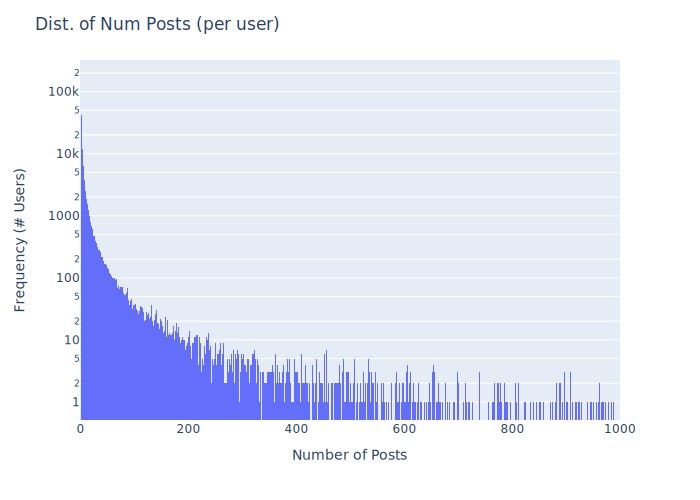

In [26]:
fig = px.histogram(x=posts.groupby('OwnerUserId').size(), log_y=True, range_x=(0, 1000))
fig.update_traces(xbins=dict( # bins used for histogram
        start=0,
        end=1000,
        size=1
    ))
fig.update_layout(height=500, width=700, title='Dist. of Num Posts (per user)',
                  xaxis_title='Number of Posts', yaxis_title='Frequency (# Users)')

In [27]:
num_answers = posts.groupby('ParentId').size()
# posts.set_index('Id', inplace=True)
posts.loc[num_answers.index, 'num_answers'] = num_answers.values
posts['num_answers'].fillna(0, inplace=True)

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_91960/776345772.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_91960/776345772.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/08/91_vkqq52qg5phplpc

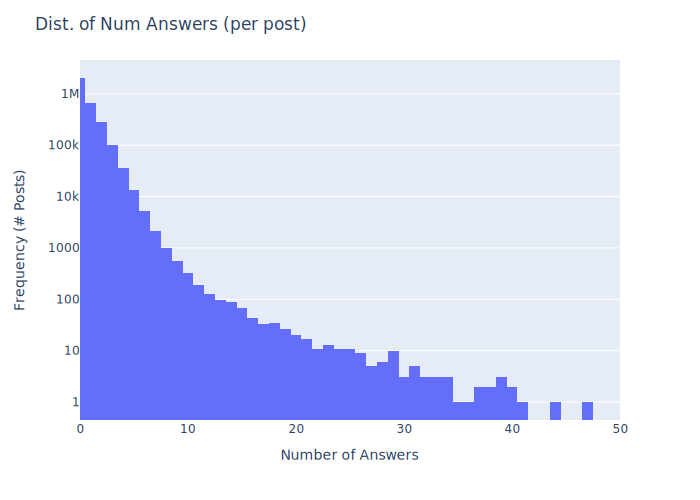

In [28]:
fig = px.histogram(posts, x='num_answers', log_y=True, range_x=(0, 50))
fig.update_layout(height=500, width=700, title='Dist. of Num Answers (per post)',
                  xaxis_title='Number of Answers', yaxis_title='Frequency (# Posts)')

In [29]:
posts['post_length'] = posts.Body.str.len()

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_91960/3049498844.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



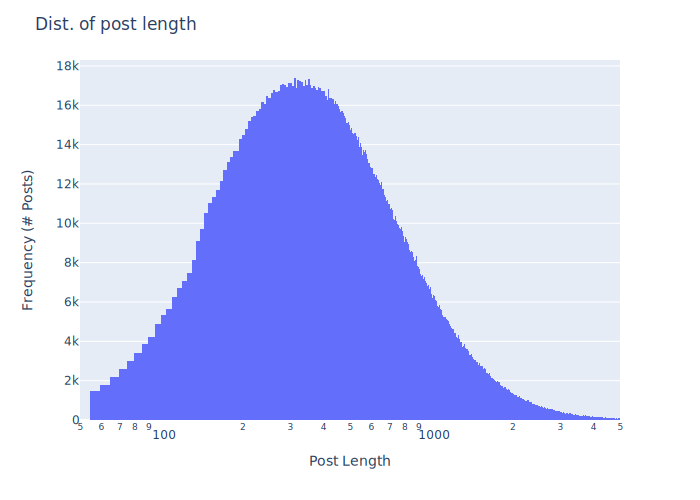

In [30]:
fig = px.histogram(posts, x='post_length', log_x=True, range_x=(50, 5_000))
fig.update_layout(height=500, width=700, title='Dist. of post length',
                  xaxis_title='Post Length', yaxis_title='Frequency (# Posts)')

In [31]:
# posts per user over time
posts_per_user = (
    posts.groupby(posts.CreationDate.dt.strftime('%Y-%m')).size()
    / users.groupby(users.CreationDate.dt.strftime('%Y-%m')).size().cumsum()
)

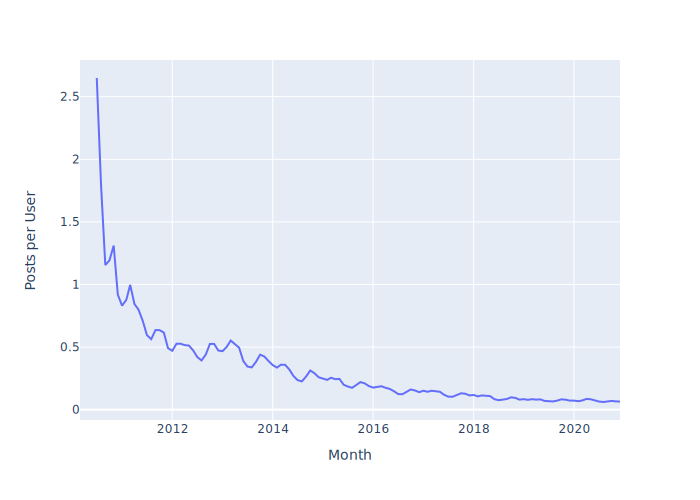

In [32]:
fig = px.line(x=posts_per_user.index, y=posts_per_user.values, width=700, height=500)
fig.update_layout(xaxis_title='Month', yaxis_title='Posts per User')

In [33]:
def get_tag_list(tag_str: str) -> list[str]:
    return tag_str.strip('<>').split('><')

print(get_tag_list('<elementary-set-theory><intuition><infinity><faq>'))
print(get_tag_list('<computer-science>'))

['elementary-set-theory', 'intuition', 'infinity', 'faq']
['computer-science']


In [34]:
posts.Tags.head()

0                                   <computer-science>
1                                                  NaN
2    <elementary-set-theory><intuition><infinity><faq>
3          <soft-question><big-list><online-resources>
4                                                  NaN
Name: Tags, dtype: object

**Notes**
- Seasonality preserved.
- Power laws in number of posts (per user) and number of answers (per post)
- Post length has interesting dist (may be informative for churn?)
- Tags likely not informative (gut feeling is that signal will have been captured in other feats.)
- Post rate per user goes down because of churn (interesting to look at per active user w/ more time).
- Can focus solely on questions (type == 1) and answers (type == 2), other types are too rare.

### PostHistory

In [35]:
post_hist = dataset.db.table_dict['postHistory'].df
print(f'Total Post History records: {len(post_hist):,}')

Total Post History records: 9,366,557


In [36]:
post_hist.PostHistoryTypeId.value_counts(normalize=True)

PostHistoryTypeId
2.0     0.335372
5.0     0.247659
1.0     0.141061
3.0     0.140915
4.0     0.039313
6.0     0.034323
24.0    0.020861
10.0    0.009229
13.0    0.005828
12.0    0.005807
50.0    0.004192
33.0    0.002977
34.0    0.002964
25.0    0.002928
16.0    0.001931
8.0     0.001080
11.0    0.000741
36.0    0.000661
52.0    0.000617
7.0     0.000356
53.0    0.000312
9.0     0.000239
19.0    0.000201
38.0    0.000182
14.0    0.000119
15.0    0.000061
37.0    0.000053
20.0    0.000009
35.0    0.000007
22.0    0.000003
Name: proportion, dtype: float64

In [37]:
# posts closed or deleted
post_hist[post_hist.PostHistoryTypeId.isin({10, 12})].PostId.nunique()

133651

In [38]:
# post tweeted
post_hist[post_hist.PostHistoryTypeId == 25].PostId.nunique()

27422

### Votes

In [39]:
votes = dataset.db.table_dict['votes'].df
print(f'Total votes: {len(votes):,}')

Total votes: 9,721,558


In [40]:
votes.isna().mean()

Id              0.000000
CreationDate    0.000000
UserId          0.997042
PostId          0.150872
VoteTypeId      0.000000
dtype: float64

In [41]:
# see full schema for type descriptions
votes['is_positive'] = votes.VoteTypeId.isin({1, 2, 5, 8, 16})
votes['is_negative'] = votes.VoteTypeId.isin({3, 4, 6, 10, 12})

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_91960/3146523349.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_91960/3146523349.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



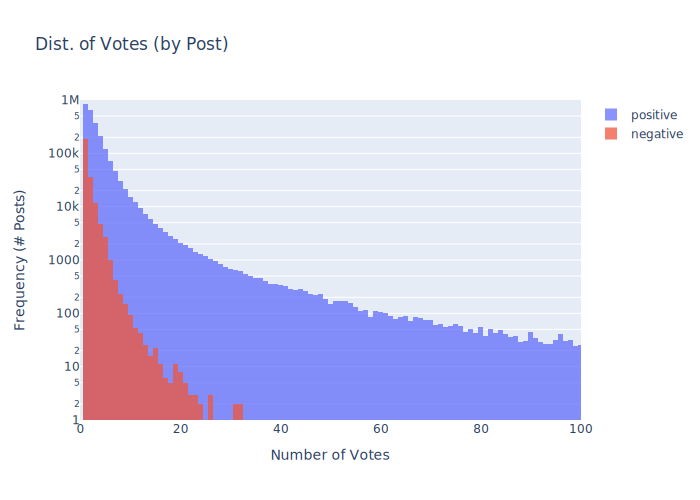

In [42]:
fig = go.Figure(
    [
            go.Histogram(x=votes[votes.is_positive].groupby('PostId').size(), name='positive', ),
            go.Histogram(x=votes[votes.is_negative].groupby('PostId').size(), name='negative')
    ],
    layout=dict(barmode='overlay')
)
# fig = px.histogram(x=votes[votes.is_positive].groupby('PostId').size(), log_y=True, range_x=(0, 100))
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log", range=[0, 6])
fig.update_xaxes(range=[0, 100])
fig.update_layout(height=500, width=700, title='Dist. of Votes (by Post)',
                  xaxis_title='Number of Votes', yaxis_title='Frequency (# Posts)')

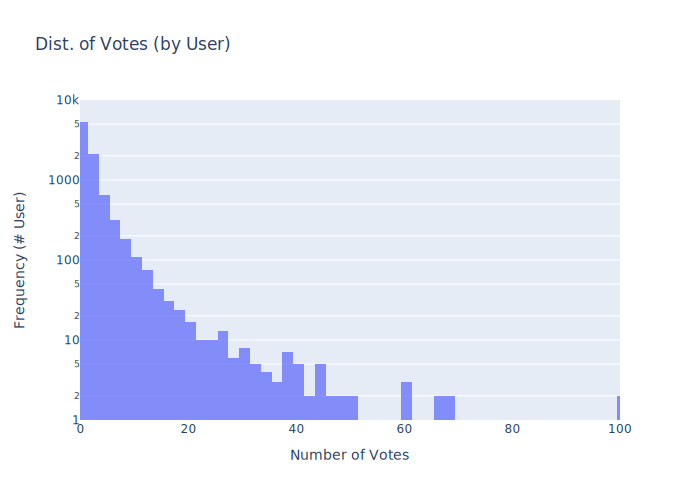

In [43]:
fig = go.Figure(
    [
            go.Histogram(x=votes[votes.is_positive].groupby('UserId').size(), name='positive'),
            go.Histogram(x=votes[votes.is_negative].groupby('UserId').size(), name='negative')
    ],
    layout=dict(barmode='overlay')
)
# fig = px.histogram(x=votes[votes.is_positive].groupby('PostId').size(), log_y=True, range_x=(0, 100))
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log", range=[0, 4])
fig.update_xaxes(range=[0, 100])
fig.update_layout(height=500, width=700, title='Dist. of Votes (by User)',
                  xaxis_title='Number of Votes', yaxis_title='Frequency (# User)')

In [44]:
votes[votes.is_negative].UserId.isna().mean()

1.0

**Notes**:
- `UserId` is only present for `VoteTypeId` 5, 6, 7, 8 (unsure why) -- so user level feats only possible w/ positive votes
- "positive" engagements are more common (per post) than negative engagements
- Look at comment rate (ie comments per week/month)

### Comments

In [45]:
comments = dataset.db.table_dict['comments'].df
print(f'Total comments: {len(comments):,}')

Total comments: 5,711,000


In [46]:
comments.isna().mean()

Id                 0.000000e+00
Text               5.253020e-07
ContentLicense     0.000000e+00
CreationDate       0.000000e+00
UserId             4.647697e-02
UserDisplayName    9.533619e-01
PostId             3.502014e-07
dtype: float64

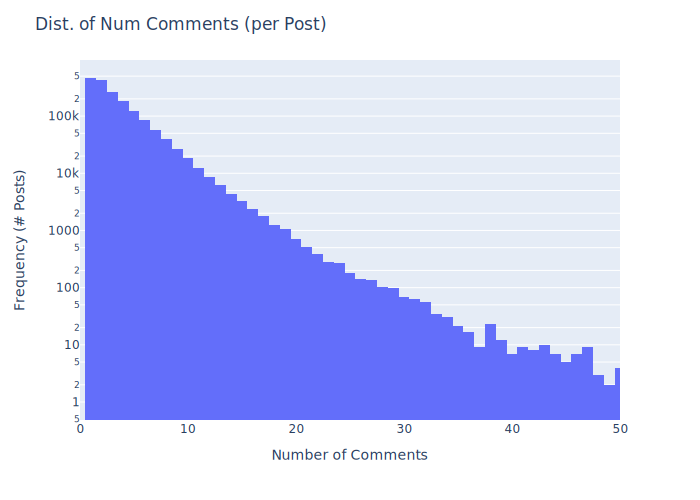

In [47]:
fig = px.histogram(x=comments.groupby('PostId').size(), log_y=True, range_x=(0, 50))
fig.update_layout(height=500, width=700, title='Dist. of Num Comments (per Post)',
                  xaxis_title='Number of Comments', yaxis_title='Frequency (# Posts)')

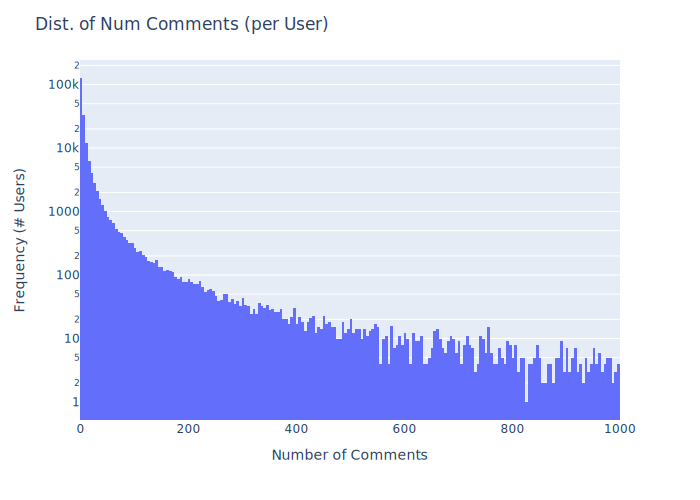

In [48]:
fig = px.histogram(x=comments.groupby('UserId').size(), log_y=True, range_x=(0, 1000))
fig.update_layout(height=500, width=700, title='Dist. of Num Comments (per User)',
                  xaxis_title='Number of Comments', yaxis_title='Frequency (# Users)')